### unsupervised CVAE
- 비지도의 방식으로 CVAE를 구성했을 때, semi-supervised에 얼마나 근접할 지 알아보자.

#### 오토인코더에 컨디션을 주면 잠재 공간의 분포는 어떤 모습을 띌까?
- 각 클래스 별로 동일한 분포를 가질 것이다.

In [14]:
import torch
from torch import nn
import torch.nn.functional as F

class My_Encoder(nn.Module):
    def __init__(self, dim_encoder_output, num_class, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(784 + num_class, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x, label):
        x = torch.cat([x, label], dim=1)
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, num_class, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input + num_class, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, 784)

    def forward(self, z, label):
        z = torch.cat([z, label], dim=1)
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        return x_hat


In [15]:
from myAE import Manager

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(2, 10), My_Decoder(2, 10))

def calc_loss(model, x, y, F, device):
    label = F.one_hot(y, 10)
    z = model.get_submodule("encoder")(x, label)
    x_hat = model.get_submodule("decoder")(z, label)
    loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
    return loss

hist = manager.train(calc_loss, epochs=30)

Now, it is working on cuda:1.


100%|██████████| 30/30 [02:26<00:00,  4.88s/it]


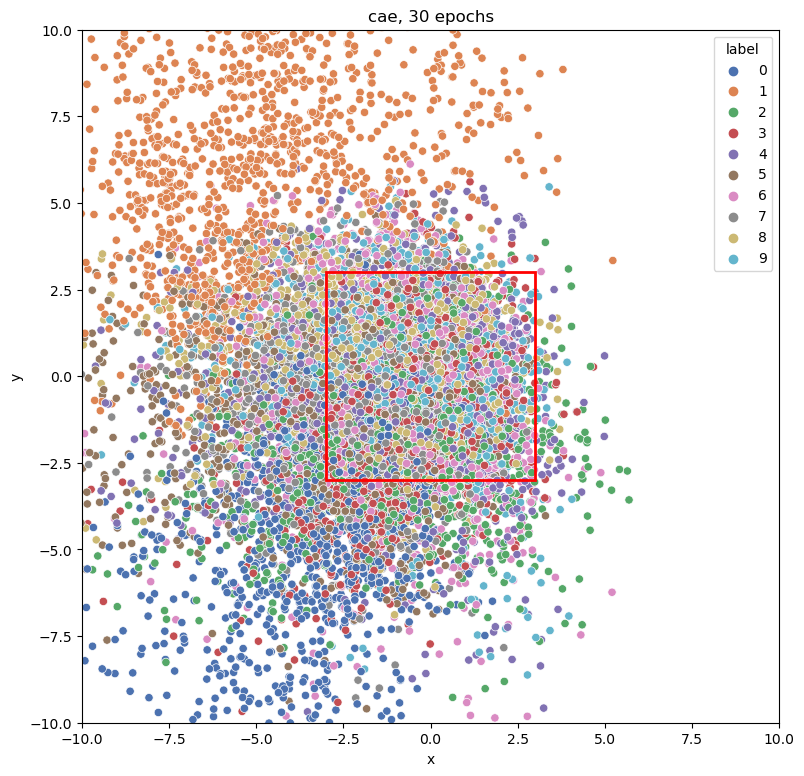

In [17]:
def encode(model, x, y):
    label = F.one_hot(y, 10)
    z = model.get_submodule("encoder")(x, label)
    return [z]

manager.show_latent_space('cae, 30 epochs', encode)

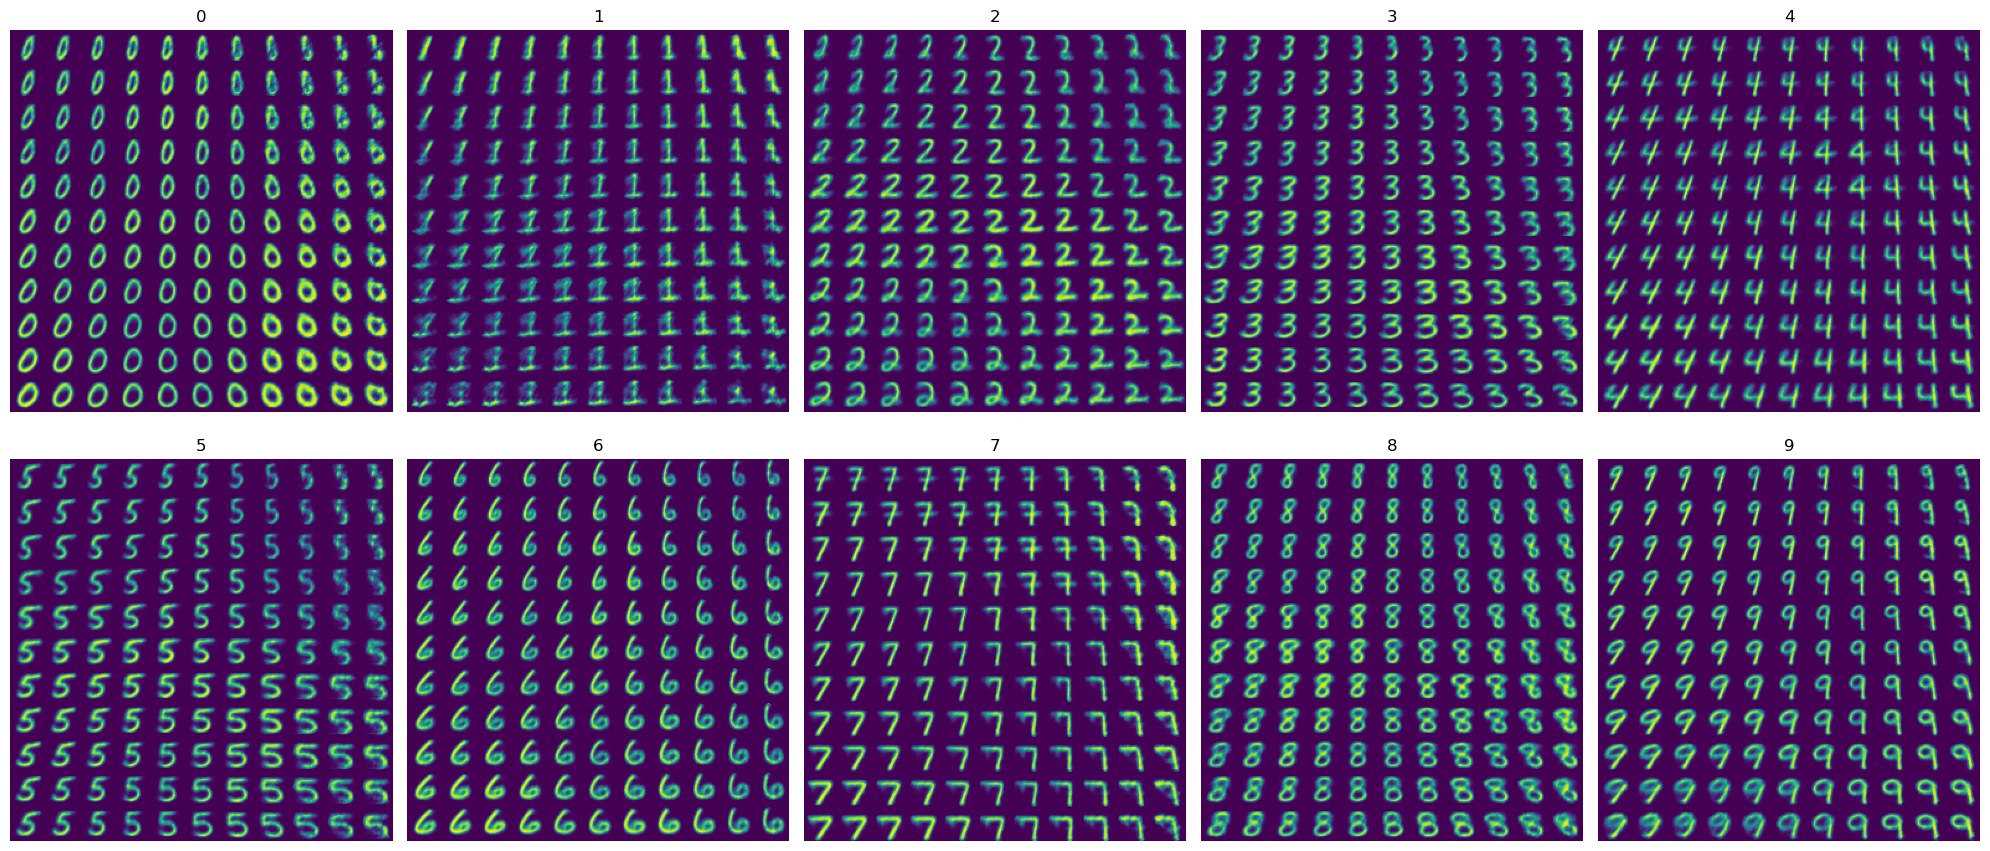

In [18]:
import matplotlib.pyplot as plt

grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 11), torch.linspace(-3, 3, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
    _, (ax_1, ax_2) = plt.subplots(nrows=2, ncols=5, figsize=[20, 9])
    for idx in range(5):
        w = 28
        n = len(points)
        img = torch.zeros((n*w, n*w))
        for i, r in enumerate(points):
            p = F.one_hot(torch.tensor([idx]*len(r)), 10)
            tmps = decoder(r, p).view([-1, 1, 28, 28])
            for j, tmp in enumerate(tmps):
                img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
        ax_1[idx].axis('off')
        ax_1[idx].imshow(img)
        ax_1[idx].title.set_text(idx)

    for idx in range(5, 10):
        w = 28
        n = len(points)
        img = torch.zeros((n*w, n*w))
        for i, r in enumerate(points):
            p = F.one_hot(torch.tensor([idx]*len(r)), 10)
            tmps = decoder(r, p).view([-1, 1, 28, 28])
            for j, tmp in enumerate(tmps):
                img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
        ax_2[idx - 5].axis('off')
        ax_2[idx - 5].imshow(img)
        ax_2[idx - 5].title.set_text(idx)

    plt.tight_layout()
    plt.show()

with torch.no_grad():
  plot_reconstructed(manager.model.get_submodule('decoder'), points)
  

In [19]:
from myAE import Manager

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(2, 10), My_Decoder(2, 10))

def calc_loss(model, x, y, F, device):
    label = F.one_hot(y, 10)
    z = model.get_submodule("encoder")(x, label)
    x_hat = model.get_submodule("decoder")(z, label)
    loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
    return loss

hist = manager.train(calc_loss, epochs=30)

Now, it is working on cuda:1.


100%|██████████| 30/30 [02:25<00:00,  4.86s/it]


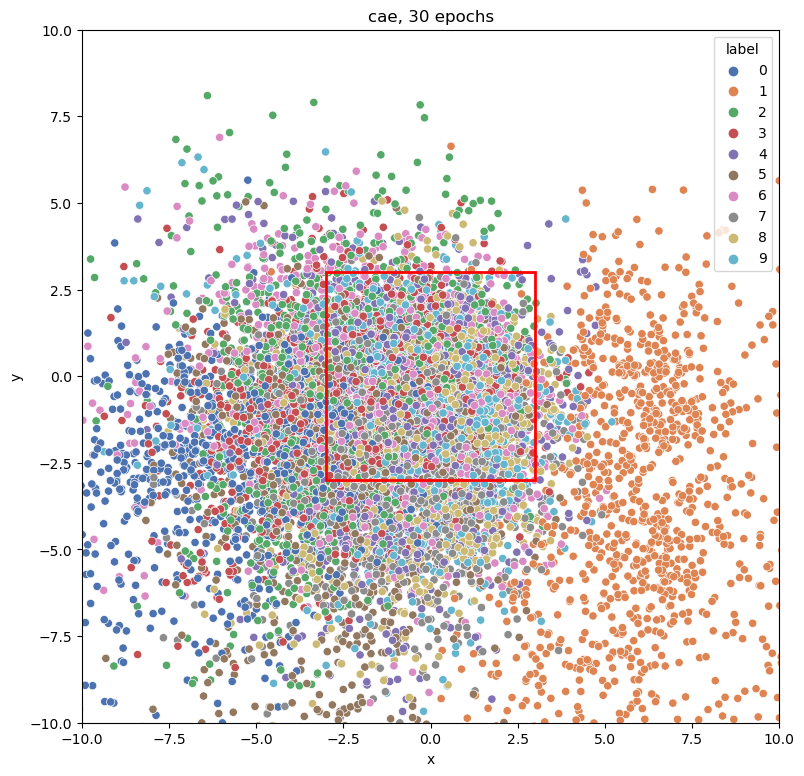

In [20]:
def encode(model, x, y):
    label = F.one_hot(y, 10)
    z = model.get_submodule("encoder")(x, label)
    return [z]

manager.show_latent_space('cae, 30 epochs', encode)

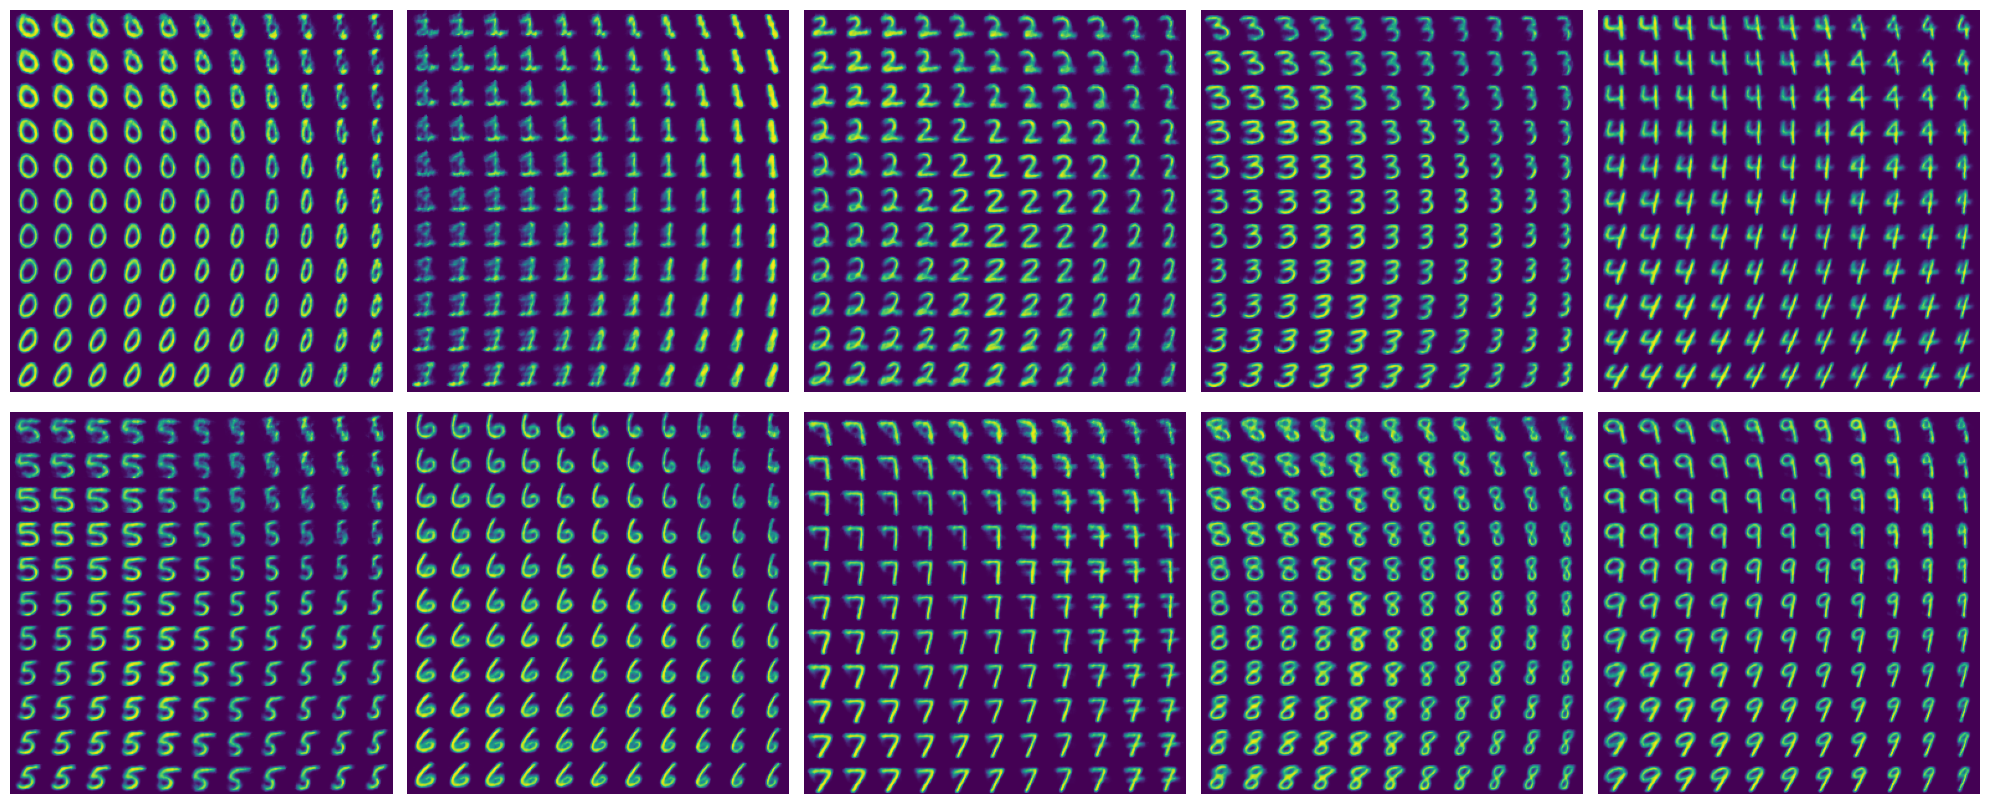

In [24]:
import matplotlib.pyplot as plt

grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 11), torch.linspace(-3, 3, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
    _, (ax_1, ax_2) = plt.subplots(nrows=2, ncols=5, figsize=[20, 8.5])
    for idx in range(5):
        w = 28
        n = len(points)
        img = torch.zeros((n*w, n*w))
        for i, r in enumerate(points):
            p = F.one_hot(torch.tensor([idx]*len(r)), 10)
            tmps = decoder(r, p).view([-1, 1, 28, 28])
            for j, tmp in enumerate(tmps):
                img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
        ax_1[idx].axis('off')
        ax_1[idx].imshow(img)

    for idx in range(5, 10):
        w = 28
        n = len(points)
        img = torch.zeros((n*w, n*w))
        for i, r in enumerate(points):
            p = F.one_hot(torch.tensor([idx]*len(r)), 10)
            tmps = decoder(r, p).view([-1, 1, 28, 28])
            for j, tmp in enumerate(tmps):
                img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
        ax_2[idx - 5].axis('off')
        ax_2[idx - 5].imshow(img)

    plt.tight_layout()
    plt.show()

with torch.no_grad():
  plot_reconstructed(manager.model.get_submodule('decoder'), points)
  

#### 오토 인코더에 컨디션을 추가했을 때...
- 실험을 해 보기 전에는, 각 클래스별 분포가 동일하리라고 예상했지만 실험에서 나타난 결과는 서로 다른 분포를 보였다.
- 오토 인코더의 손실 함수는 입력과 출력 간의 오차를 평가한다. 따라서 실험에서 나타난 결과로 짐작할 수 있는 사실은 클래스 마다 서로 다른 분포를 가지는 것이 더나은 출력을 만드는 방식(주어진 구조의 오토 인코더가)이라는 것이다. 

In [50]:
from myAE import SDC_AE
import torch
from torch import nn


class U_Encoder(nn.Module):
    def __init__(self, dim_encoder_output, num_class, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh

        # classifier
        self.lc0 = nn.Linear(784, 512)
        self.lc1 = nn.Linear(512, 512)
        self.lc2 = nn.Linear(512, num_class)

        # encoder
        self.le0 = nn.Linear(784 + num_class, 512)
        self.le1 = nn.Linear(512, 512)
        self.le2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x):
        p = self.activation(self.lc0(x))
        p = self.activation(self.lc1(p))
        p = self.lc2(p)

        prob = F.softmax(p, dim=1)
        max_arg = prob.argmax(dim=1)
        pred_label = F.one_hot(max_arg, 10)

        xp = torch.cat([x, pred_label], dim=1)

        z = self.activation(self.le0(xp))
        z = self.activation(self.le1(z))
        z = self.le2(z)
        return z, pred_label

class U_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, num_class, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input + num_class, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, 784)

    def forward(self, z, pred_label):
        z = torch.cat([z, pred_label], dim=1)
        h = self.activation(self.l0(z))
        h = self.activation(self.l1(h))
        x_hat = torch.sigmoid(self.l2(h))
        return x_hat

In [55]:
manager = SDC_AE()
manager.prepare_data()
manager.set_model(U_Encoder(2, 10), U_Decoder(2, 10))

def calc_loss(model, x, y, F, device):
  z, pred_label = model.get_submodule("encoder")(x)
  x_hat = model.get_submodule("decoder")(z, pred_label)
  loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
  return loss

hist = manager.train(calc_loss, epochs=50)

Now, it is working on cuda:1.


100%|██████████| 50/50 [04:05<00:00,  4.92s/it]


<AxesSubplot:xlabel='x', ylabel='y'>

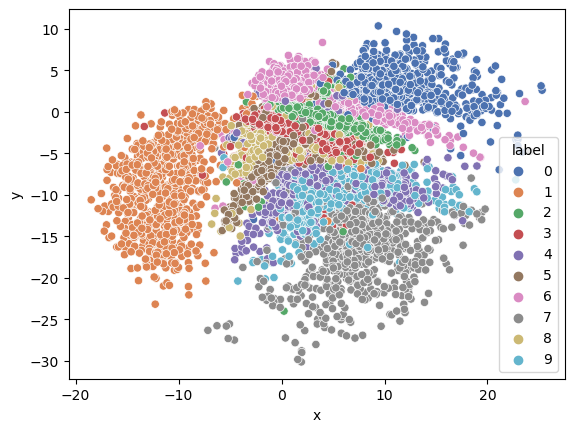

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(columns=['x', 'y', 'label'])

manager.model.to('cpu')
manager.model.eval()

with torch.no_grad():
  idx = 0
  for x, y in manager.train_dataloader:
    x = x.reshape([-1, 28*28])
    zs = manager.model.get_submodule('encoder')(x)
    
    tmp = pd.DataFrame(
      {
        'x': zs[0][:, 0],
        'y': zs[0][:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    idx += 1
    if idx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

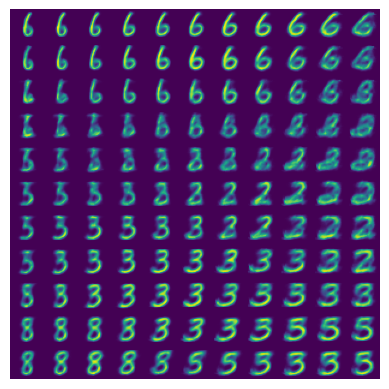

In [57]:
import matplotlib.pyplot as plt

grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 11), torch.linspace(-3, 3, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    p = F.one_hot(torch.tensor([1]*len(r)), 10)
    tmps = decoder(r, p).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(manager.model.get_submodule('decoder'), points)
  

In [46]:
# 10 번씩 하는 것


manager = SDC_AE()
manager.prepare_data()
manager.set_model(U_Encoder(2, 10), U_Decoder(2, 10))



def calc_loss(model, x, y, F, device):

  tmp_batch_size = len(x)

  label = torch.cat([F.one_hot(torch.arange(10), 10)]*tmp_batch_size, dim=0)
  label = label.to(device)

  p = model.get_submodule("encoder").class_predict(x)
  
  
  with torch.no_grad():
    
    
    z = model.get_submodule("encoder")(x)
    z10 = torch.cat([z]*10, dim=1).view(-1, 2)
    x_hat10 = model.get_submodule("decoder")(z10, label)
    x10 = torch.cat([x]*10, dim=1).view(-1, 784)

    loss10 = -(x10*x_hat10.log() + (1-x10)*(1-x_hat10).log()).sum(dim=1)
    min_loss_label = loss10.view(tmp_batch_size, -1).argmin(dim=1)
  pred_label = F.one_hot(min_loss_label, 10).to(torch.float)
  z, p = model.get_submodule("encoder")(x)
  prob = F.softmax(p, dim=1)
  x_hat = model.get_submodule("decoder")(z, pred_label)
  loss = F.cross_entropy(prob, pred_label, reduction='sum')/len(x) + F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
  return loss

hist = manager.train(calc_loss, epochs=50)

Now, it is working on cuda:1.


100%|██████████| 50/50 [04:53<00:00,  5.87s/it]


<AxesSubplot:xlabel='x', ylabel='y'>

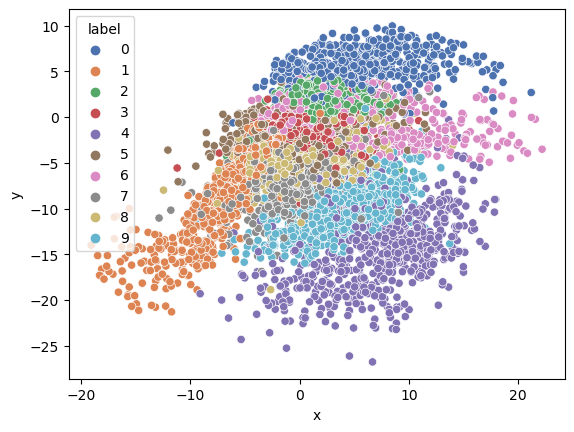

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(columns=['x', 'y', 'label'])

manager.model.to('cpu')
manager.model.eval()

with torch.no_grad():
  idx = 0
  for x, y in manager.train_dataloader:
    x = x.reshape([-1, 28*28])
    zs = manager.model.get_submodule('encoder')(x)
    
    tmp = pd.DataFrame(
      {
        'x': zs[0][:, 0],
        'y': zs[0][:, 1],
        'label': y
      }
    )
    df = pd.concat([df, tmp], ignore_index=True)

    idx += 1
    if idx > 50:
      break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

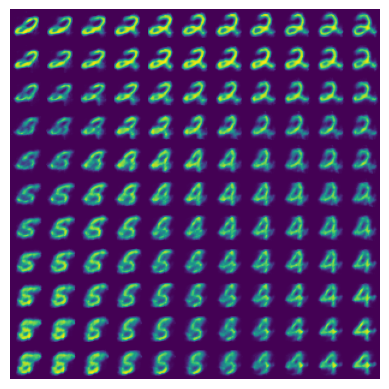

In [48]:
import matplotlib.pyplot as plt

grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 11), torch.linspace(-3, 3, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    # args = (torch.stack([table[:, 0]]*len(r), dim=2).view(-1, len(r), 2) - r).norm(dim=2).argmin(dim=0)
    # sample_z_1 = table[args][:, 1]
    # sample_z_2 = table[args][:, 2]
    # print(r)
    # print(args)
    # print(table[args])
    p = F.one_hot(torch.tensor([0]*len(r)), 10)
    tmps = decoder(r, p).view([-1, 1, 28, 28])
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(manager.model.get_submodule('decoder'), points)
  